<center><h1> Projet Deep Learning<h1></center>
<center><h5>Fabien HOS - MASTER2 MEDAS - CNAM<h5></center>

In [30]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

# Tensorflow & Keras 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from kerastuner.tuners import Hyperband


Dans ce projet, nous allons chercher à prédire correctement les 10 classes de vêtements du jeu de données FASHION_MNIST.
Nous allons pour cela comparer plusieurs modèles, nous commençerons par utiliser la régression logistique (un modèle y ressemblant), puis le MLP et enfin le CNN. Pour comparer les modèles entre eux, nous utiliserons la métrique suivante : <b>la précision.</b>

In [32]:
# convert class vectors to binary class matrices
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# Affichage des formes des datasets pour comprendre la structure
print("Training set shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test set shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Training set shape: (60000, 28, 28)
Training labels shape: (60000,)
Test set shape: (10000, 28, 28)
Test labels shape: (10000,)


On commence par importer le jeu de données puis on regarde leurs formes, nous voyons que le jeu de données est composé de 60 000 images pour l'apprentissage et 10 000 de test. Leur forme de 28x28 pixels.

Dans la cellule ci-dessous, on peut éventuellement regarder à quoi ressemble nos images, nous voyons ici : une chaussure et deux t-shirt en niveau de gris.

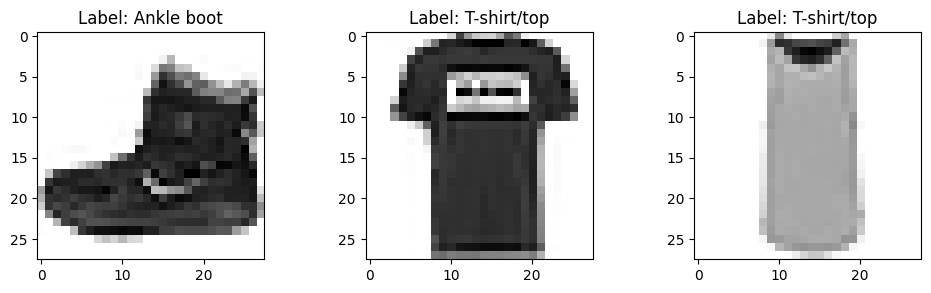

In [33]:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def show_image(img, label, ax):
    ax.imshow(img, cmap=plt.cm.binary)
    ax.set_title(f"Label: {class_names[label]}")  

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i in range(3):
    show_image(X_train[i], y_train[i], ax=axes[i])

plt.tight_layout()
plt.show()


# Preprocessing
Nous allons maintenant procéder à la normalisation des données et à l'encodage des labels. 

In [34]:
# Normalization
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)



# Régression Logistique

Notre premier modèle sera une équivalence de la régression logistique. On utilise pour cela un modèle simple avec une seule couche de 10 neurones : un pour chaque classe. Cette couche possède une activation <b>softmax</b> pour obtenir les probabilitées d'appartenance à chaque classe.

Nous compilons ensuite le modèle en utilisant un algorithme d'optimisation (<b>adam</b>) pour minimiser la fonction de perte <b>categorical_crossentropy</b>. Comme spécifié plus tôt, la métrique que l'on souhaite observer ici est la <b>précision</b>.

On entraine ensuite le modèle sur <b>10 epochs</b>, cela signifie que chaque observation sera utilisée 10 fois pour entraîner le modèle. On utilise un <b>batch_size de 32</b>, c'est à dire que toutes les 32 observations, le modèle effectuera un passage arrière (<i>backward pass</i>) après avoir calculer la perte pour rétropropager le gradient et mettre à jour les poids du modèle.  On effectue également un split (10% de la base d'entraînement) pour obtenir un jeu de validation afin d'observer <b>un éventuel sur-apprentissage</b>. 

In [36]:
# Définition du modèle
LR = Sequential([
    Flatten(input_shape=(28, 28),name='input'),
    Dense(10, activation='softmax',name='output')
], name='Regression_logistique')

LR.summary()
# Compilation du modèle
LR.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraînement du modèle avec l'ensemble de validation
history_LR = LR.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Model: "Regression_logistique"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 784)               0         
                                                                 
 output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/10
1500/1500 [==============================] - 1s 800us/step - loss: 0.6277 - accuracy: 0.7907 - val_loss: 0.5034 - val_accuracy: 0.8248
Epoch 2/10
1500/1500 [==============================] - 1s 735us/step - loss: 0.4734 - accuracy: 0.8380 - val_loss: 0.4783 - val_accuracy: 0.8357
Epoch 3/10
1500/1500 [==============================] - 1s 784us/step - loss: 0.4449 - accuracy: 0.8476 - val_loss: 0.4473 - val_accuracy: 0.8453
Epoch 4/10
1500/1500 [==============================] - 1s 749us/step - loss: 0.4293 - accuracy: 0.8527 - val_loss: 0.4317 - val_accuracy: 0.8507
Epoch 5/10
1500/1500 [==============================] - 1s 747us/step - loss: 0.4180 - accuracy: 0.8559 - val_loss: 0.4309 - val_accuracy: 0.8546
Epoch 6/10
1500/1500 [==============================] - 1s 707us/step - loss: 0.4105 - accuracy: 0.8578 - val_loss: 0.4518 - val_accuracy: 0.8435
Epoch 7/10
1500/1500 [==============================] - 1s 711us/step - loss: 0.4053 - accuracy: 0.8584 - val_loss: 0.4197 -

# Evaluation 
Suite à l'entrainement, nous pouvons observer nos deux fonctions de pertes (<i>Training et Validation</i>) pour regarder leur tendance respective.
<br>Nous voyons ici que la perte d'entraînement <b>diminiue</b> au fil des <i>epochs</i>, c'est le comportement attendue puisque nous cherchons <b>à la minimiser</b>.

La perte de validation quant à elle, suit la même tendance, c'est un signe que <b>le modèle s'améliore</b> et qu'il <b>généralise bien</b>.   

Nous testons ensuite notre modèle sur le jeu de données de test pour statuer de sa performance.
<br>On observe ici qu'avec <b>une précision de 84%</b> notre modèle est globalement bon, bien qu'il semble légèrement moins performer en test qu'en apprentissage, nous n'observons pas de sur-apprentissage ici.

Test accuracy: 0.84


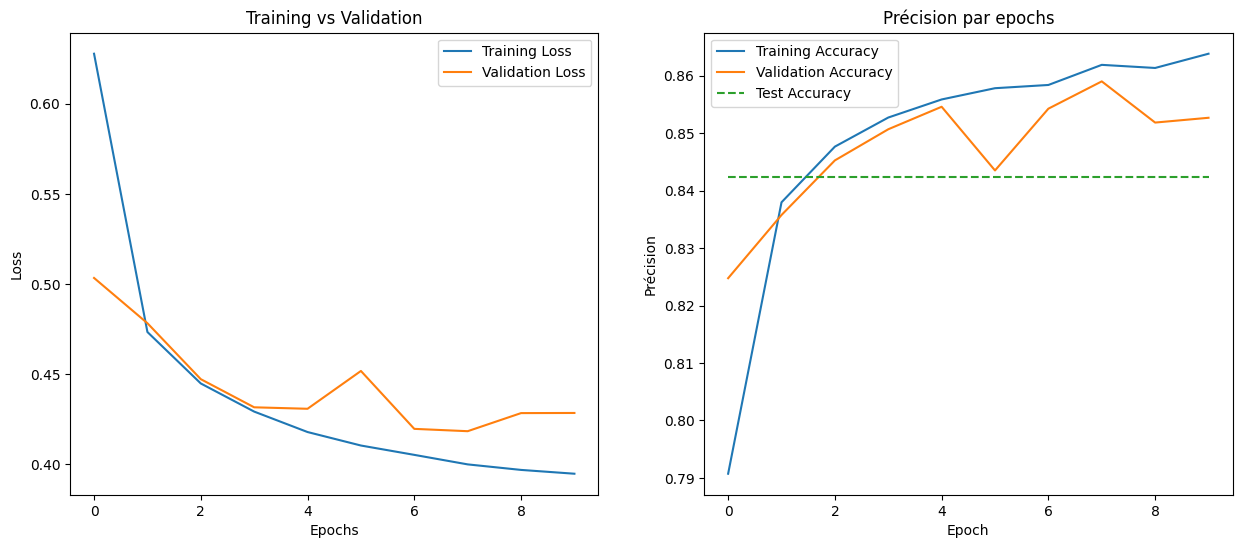

In [37]:
# Evaluer le modèle sur le jeu de données test
test_loss, test_accuracy = LR.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', round(test_accuracy,2))

plt.figure(figsize=(15, 6))
# Tracer les courbes de loss
plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, position 2
plt.plot(history_LR.history['loss'], label='Training Loss')
plt.plot(history_LR.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Tracer les courbes de précision
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, position 2
plt.plot(history_LR.history['accuracy'], label='Training Accuracy')
plt.plot(history_LR.history['val_accuracy'], label='Validation Accuracy')
plt.plot(np.arange(len(history_LR.history['accuracy'])), [test_accuracy]*len(history_LR.history['accuracy']), label='Test Accuracy', linestyle='--')
#plt.axvline(x=8, color='r')
plt.title('Précision par epochs')
plt.xlabel('Epoch')
plt.ylabel('Précision')
plt.legend()

plt.show()




# Premier modèle MLP
Nous allons maintenant créer notre premier modèle MLP, nous allons construire un modèle très simple avec 1 couche entièrement connecté de 128 neurones et une couche de 10 neurones pour la sortie. 
<br>Les hyperparamètres utilisés seront également très classique, on utilisera un <b>batch_size de 32</b>, <b>10 epochs</b> (chaque observation sera vue 10 fois pendant l'entraînement), et un <b>learning_rate de 0.001</b> (c'est le learning_rate par défaut de l'optimiseur "adam"). (https://keras.io/api/optimizers/adam/)
<br>En guise de fonction d'activation pour notre couche cachée, nous utiliserons <b>'ReLU'</b> pour sa rapidité. 
<br>En sortie, on utilisera <b>'softmax'</b> pour obtenir les probabilités d'appartenance à chaque classe. 
<br>On utilisera <b>'categorial_crossentropy'</b> en fonction de perte car elle est adaptée à notre problème de <b>classification multiclasse</b>. 

In [40]:
# Construire le modèle MLP
MLP1 = Sequential([ 
    Flatten(input_shape=(28, 28),name='input'),
    Dense(128, activation = 'relu',name='hidden_1'), # couche cachée de 128 neurones
    Dense(10, activation = 'softmax',name='output')
],name='Modele_simple')

# Afficher le modèle
MLP1.summary()

# Compiler le modèle
MLP1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraîner le modèle
history_MLP1 = MLP1.fit(X_train,
                    y_train, 
                    epochs=10, 
                    batch_size=32, 
                    validation_split=0.2)



Model: "Modele_simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 784)               0         
                                                                 
 hidden_1 (Dense)            (None, 128)               100480    
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5224 - accuracy: 0.8174 - val_loss: 0.4536 - val_accuracy: 0.8401
Epoch 2/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3911 - accuracy: 0.8596 - val_loss: 0.3838 - val_accuracy: 0.8620
Epoch 3/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3503 - accuracy: 0.8716 - val_loss: 0.3504 - val_accuracy: 0.8742
Epoch 4/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3233 - accuracy: 0.8826 - val_loss: 0.3436 - val_accuracy: 0.8756
Epoch 5/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3045 - accuracy: 0.8872 - val_loss: 0.3502 - val_accuracy: 0.8749
Epoch 6/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2888 - accuracy: 0.8937 - val_loss: 0.3378 - val_accuracy: 0.8769
Epoch 7/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2769 - accuracy: 0.8982 - val_loss: 0.3308 - val_accuracy:

# Evaluation 
Ce premier modèle MLP <b>est meilleur</b> que le modèle précédent, nous obtenons une précision de <b>90% en apprentissage</b> et de <b>88% en test</b>.

313/313 [==============================] - 0s 833us/step - loss: 0.3379 - accuracy: 0.8855
Test accuracy: 0.886


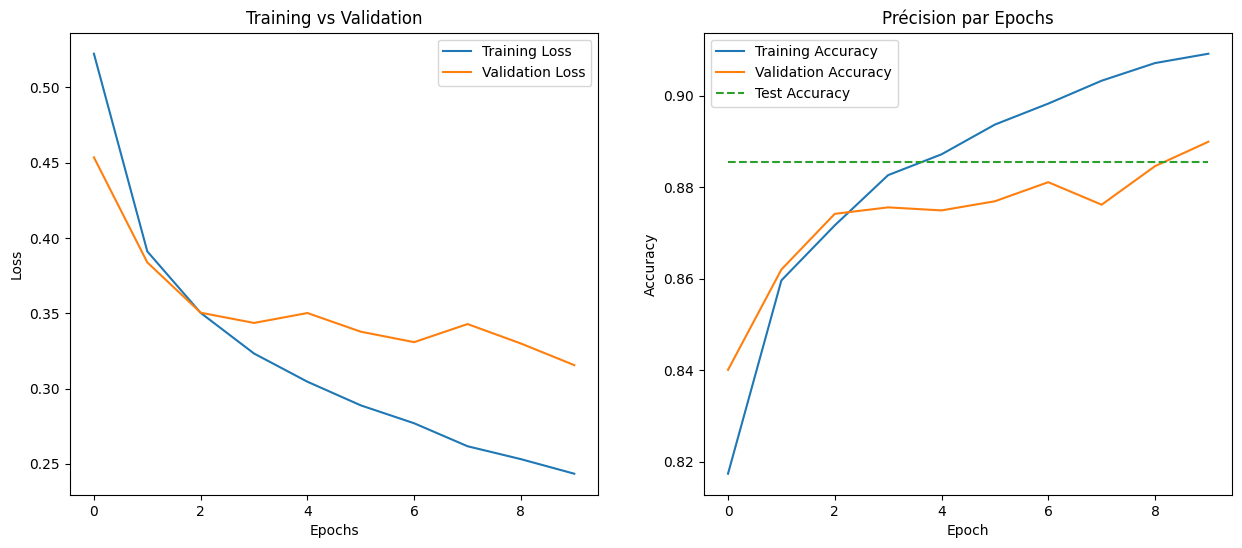

In [42]:
# Évaluer le modèle
test_loss, test_acc = MLP1.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

plt.figure(figsize=(15, 6))
# Tracer les courbes de loss
plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, position 1
plt.plot(history_MLP1.history['loss'], label='Training Loss')
plt.plot(history_MLP1.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Courbes de précision
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, position 2
plt.plot(history_MLP1.history['accuracy'], label='Training Accuracy')
plt.plot(history_MLP1.history['val_accuracy'], label='Validation Accuracy')
plt.plot(np.arange(len(history_MLP1.history['accuracy'])), [test_acc]*len(history_MLP1.history['accuracy']), label='Test Accuracy', linestyle='--')
plt.title('Précision par Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Second modèle MLP

Nous allons construire un modèle plus profond, on utilisera 6 couches cachées avec un nombre de neurones dégressifs par couche.
<br>Notre nombre de paramètres sera 15 fois plus grand (1 503 530 vs 101 770), on pourrait s'attendre à de meilleurs résultats

In [44]:
# Construire le modèle MLP complexe
MLP2 = Sequential([
    Flatten(input_shape=(28, 28),name='input'),
    Dense(1024,activation='relu',name='hiden_1'),  # Première couche cachée avec 1024 neurones
    Dense(512, activation='relu',name='hiden_2'),  # Deuxième couche cachée avec 512 neurones
    Dense(256, activation='relu',name='hiden_3'),  # Troisième couche cachée avec 256 neurones
    Dense(128, activation='relu',name='hiden_4'),  # Quatrième couche cachée avec 128 neurones
    Dense(64, activation='relu',name='hiden_5'),   # Cinquième couche cachée avec 64 neurones
    Dense(32, activation='relu',name='hiden_6'),   # Sixième couche cachée avec 32 neurones
    Dense(10, activation='softmax',name='output') # Couche de sortie avec 10 neurones pour les 10 classes
],name='MLP_profond')
MLP2.summary()
# Compiler le modèle
MLP2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraîner le modèle
history_MLP2 = MLP2.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)



Model: "MLP_profond"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 784)               0         
                                                                 
 hiden_1 (Dense)             (None, 1024)              803840    
                                                                 
 hiden_2 (Dense)             (None, 512)               524800    
                                                                 
 hiden_3 (Dense)             (None, 256)               131328    
                                                                 
 hiden_4 (Dense)             (None, 128)               32896     
                                                                 
 hiden_5 (Dense)             (None, 64)                8256      
                                                                 
 hiden_6 (Dense)             (None, 32)                

# Evaluation 

Ce modèle, bien que beaucoup plus grand en terme de paramètres, ne fournis <b>pas de résultats satisfaisants</b>.
<br>Il est moins précis de <b>1%</b> par rapport au modèle plus simple (87% vs 88%).
<br>On peut dire que la taille ne semble pas compter ici ! 🙄
<br>De plus le modèle, par sa taille, est <b>beaucoup plus à s'exécuter</b> (2min vs 19sec).

313/313 [==============================] - 1s 2ms/step - loss: 0.3681 - accuracy: 0.8766
Test accuracy: 0.877


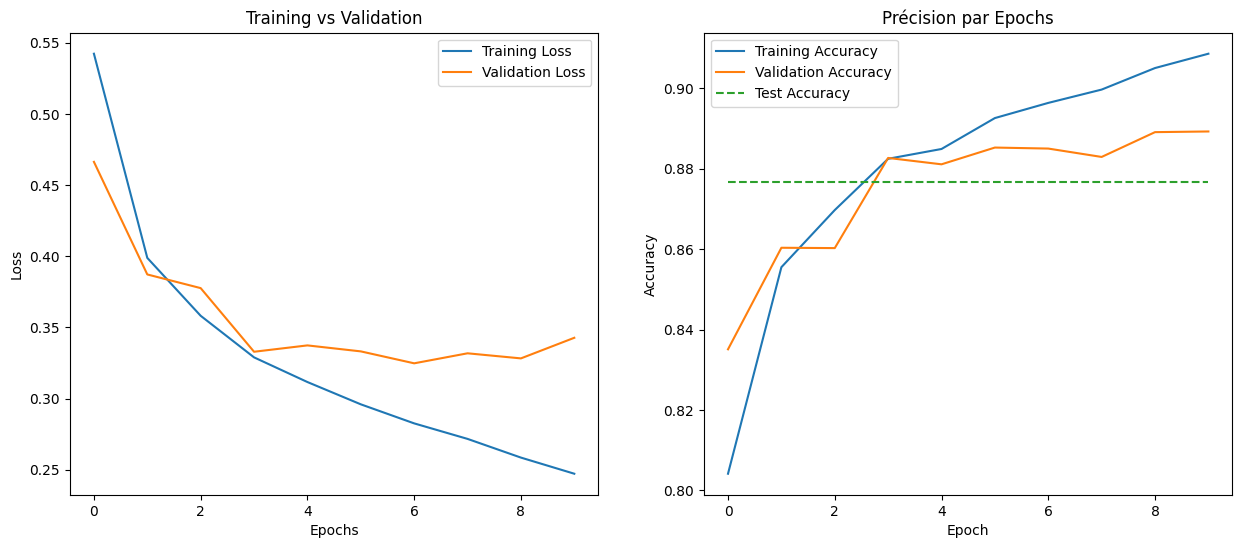

In [46]:
# Évaluer le modèle
test_loss, test_acc = MLP2.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

plt.figure(figsize=(15, 6))
# Tracer les courbes de loss
plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, position 1
plt.plot(history_MLP2.history['loss'], label='Training Loss')
plt.plot(history_MLP2.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Courbes de précision
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, position 2
plt.plot(history_MLP2.history['accuracy'], label='Training Accuracy')
plt.plot(history_MLP2.history['val_accuracy'], label='Validation Accuracy')
plt.plot(np.arange(len(history_MLP2.history['accuracy'])), [test_acc]*len(history_MLP2.history['accuracy']), label='Test Accuracy', linestyle='--')
plt.title('Précision par Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Troisième modèle MLP 
Nous avons vu que rajouté des couches ne semblait pas être une solution forcément viable.
<br>Nous pouvons essayer de le réduire en rajoutant plus de neurones dans la couche cachée et de changer la fonction d'activation. 
<br>Avec une couche cachée de 512 neurones, le modèle a 4 fois plus de paramètres que le premier modèle et environ 3 fois moins que le second.

In [51]:
# Construire le modèle MLP avec 6 couches cachées 
MLP3 = Sequential([
    Flatten(input_shape=(28, 28),name='input'),
    Dense(512,activation='tanh',name='hiden_1'),  # Première couche cachée avec 1024 neurones
    Dense(10, activation='softmax',name='output') # Couche de sortie avec 10 neurones pour les 10 classes
],name='MLP_tanh')

MLP3.summary()
# Compiler le modèle
MLP3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraîner le modèle
history_MLP3 = MLP3.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Model: "MLP_tanh"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 784)               0         
                                                                 
 hiden_1 (Dense)             (None, 512)               401920    
                                                                 
 output (Dense)              (None, 10)                5130      
                                                                 
Total params: 407050 (1.55 MB)


Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.4928 - accuracy: 0.8240 - val_loss: 0.4021 - val_accuracy: 0.8510
Epoch 2/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3900 - accuracy: 0.8579 - val_loss: 0.3820 - val_accuracy: 0.8552
Epoch 3/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3498 - accuracy: 0.8711 - val_loss: 0.3547 - val_accuracy: 0.8688
Epoch 4/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3236 - accuracy: 0.8802 - val_loss: 0.3336 - val_accuracy: 0.8748
Epoch 5/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3055 - accuracy: 0.8862 - val_loss: 0.3240 - val_accuracy: 0.8830
Epoch 6/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2881 - accuracy: 0.8928 - val_loss: 0.3287 - val_accuracy: 0.8804

# Evaluation 
Le modèle atteint des performances sensiblement similaires aux deux modèles précédents avec une précision de 87%.

313/313 [==============================] - 0s 1ms/step - loss: 0.3486 - accuracy: 0.8776
Test accuracy: 0.878


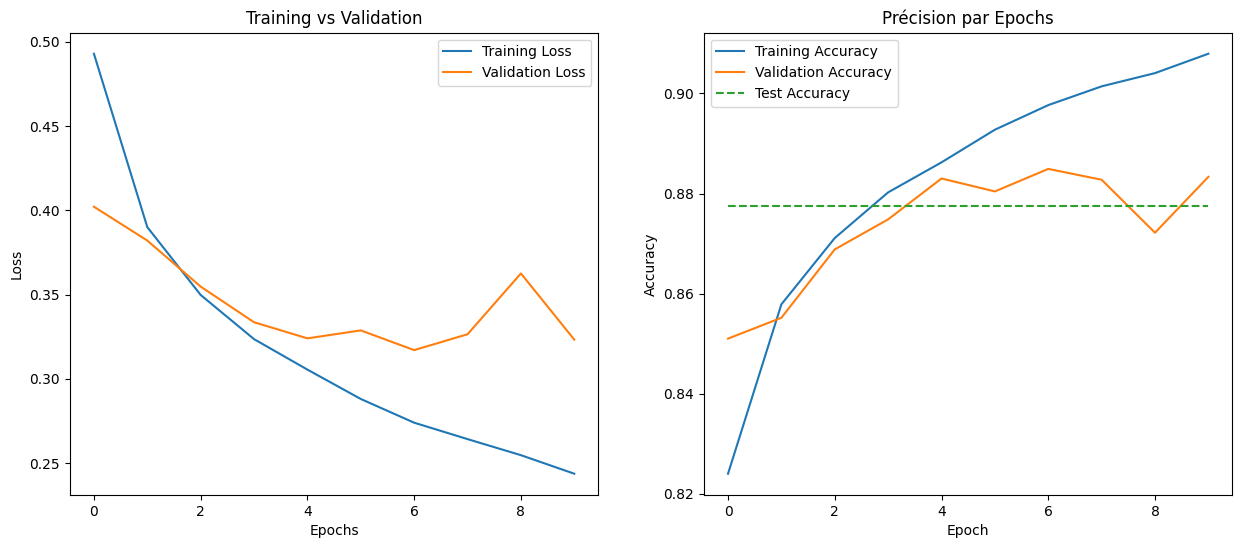

In [52]:
# Évaluer le modèle
test_loss, test_acc = MLP3.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

plt.figure(figsize=(15, 6))
# Tracer les courbes de loss
plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, position 1
plt.plot(history_MLP3.history['loss'], label='Training Loss')
plt.plot(history_MLP3.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Courbes de précision
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, position 2
plt.plot(history_MLP3.history['accuracy'], label='Training Accuracy')
plt.plot(history_MLP3.history['val_accuracy'], label='Validation Accuracy')
plt.plot(np.arange(len(history_MLP3.history['accuracy'])), [test_acc]*len(history_MLP3.history['accuracy']), label='Test Accuracy', linestyle='--')
plt.title('Précision par Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Commentaire partie MLP 
Nous pourrions essayer d'optimiser en itérant encore et encore sur l'architecture du modèle ou bien tester d'autres paramètres comme <b>le learning rate</b> ou <b>le nombre d'epochs</b> pour obtenir de meilleurs résultats.
<br>Nous ne le ferons pas car il existe un autre type de réseau plus performant pour la classification d'image, le <b>Convutionnal Neural Network</b>
<br>Ainsi nous prendrons en référence le premier modèle MLP à une couche atteignant une <b>précision de 88%</b>. Nous aimerions pouvoir passer la barre de 90% avec ce type de modèle. 

# Le CNN 
Ce type de modèle utilise de nouvelles couches : de <b>convulation</b> et de <b>pooling</b>. 
<br>Le but est de créer des filtres qui vont <i>zoomer</i> (en faisant une carte des caractéristiques) sur une image pour en construire de nouvelles.
<br>Ensuite, nous allons extraire les caractéristiques principales via une couche de <i>pooling</i>.
<br>Nous utiliserons ici de la <b>convulation 2D</b> et le <b>MaxPooling 2D</b>

In [53]:
#preprocess pour les niveaux de gris 
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

# Premier modèle CNN
Pour notre premier modèle CNN, on test un modèle simple. 
<br>On commence par une couche de convolution avec 32 filtres de taille 3x3 sur notre image d'entrée de taille 28x28 pixels avec un MaxPooling 2x2.
<p>Comme mentionné précédemment, l'objectif est d'extraire les caractéristiques, dans notre cas, les caractéristiques spécifiques des vêtements. Ces filtres vont donc permettrent de différencier un t-shirt d'une chaussure. </p>
<p>Ensuite, la couche de MaxPooling intervient. Le but principal de cette couche est de réduire la dimensionnalité des cartes de caractéristiques tout en conservant les informations les plus importantes. Elle opère en examinant des fenêtres de taille 2x2 sur chaque carte de caractéristique et en conservant la valeur maximale de chaque fenêtre. Cela a pour effet de réduire par quatre la taille de chaque carte de caractéristiques (réduisant ainsi la hauteur et la largeur de moitié), car seule la valeur maximale dans chaque fenêtre de 2x2 est conservée.</p>
<p>On <i>aplatit</i> ensuite ces cartes de caractéristiques en un vecteur au format linéaire pour la couche suivante. 

In [71]:
CNN1 = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name='Conv2D_input'),
    MaxPooling2D(pool_size=(2, 2), name='MaxPooling2D'),
    Flatten(name='Flatten'),
    Dense(128, activation='relu', name='hidden_layer_fully_connected'),
    Dense(10, activation='softmax', name='Output')
],name='CNN_1')

CNN1.summary()
CNN1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#model.fit(X_train, Y_train,batch_size=batch_size, nb_epoch=nb_epoch,verbose=1, validation_data=(X_test, Y_test))
history_CNN1 = CNN1.fit(X_train, y_train,batch_size=32, epochs=10,verbose=1,validation_split=0.2)

Model: "CNN_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_input (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 MaxPooling2D (MaxPooling2D  (None, 13, 13, 32)        0         
 )                                                               
                                                                 
 Flatten (Flatten)           (None, 5408)              0         
                                                                 
 hidden_layer_fully_connect  (None, 128)               692352    
 ed (Dense)                                                      


                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 693962 (2.65 MB)
Trainable params: 693962 (2.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.4105 - accuracy: 0.8549 - val_loss: 0.3264 - val_accuracy: 0.8814
Epoch 2/10
1500/1500 [==============================] - 13s 8ms/step - loss: 0.2756 - accuracy: 0.9007 - val_loss: 0.2855 - val_accuracy: 0.8965
Epoch 3/10
1500/1500 [==============================] - 13s 8ms/step - loss: 0.2326 - accuracy: 0.9146 - val_loss: 0.2473 - val_accuracy: 0.9102
Epoch 4/10
1500/1500 [==============================] - 12s 8ms/step - loss: 0.1973 - accuracy: 0.9270 - val_loss: 0.2696 - val_accuracy: 0.9064
Epoch 5/10
1500/1500 [==============================] 

# Evaluation 
Ce modèle CNN est satisfaisant, nous avons obtenu les <b>meilleurs résultats</b> jusqu'ici avec une précision de <b>90% en test</b>. 
<br>On remarque toutefois un <b>écart</b> entre l'apprentissage et le test (97% vs 90%).
<br>Nous pouvons tenter d'y remédier en insérant du <b>dropout</b> dans le modèle.
Le <i>dropout</i> consiste à mettre à 0 de manière aléatoire une portion définie des poids dans le réseau.

313/313 [==============================] - 1s 2ms/step - loss: 0.3383 - accuracy: 0.9090
Test accuracy: 90.90%


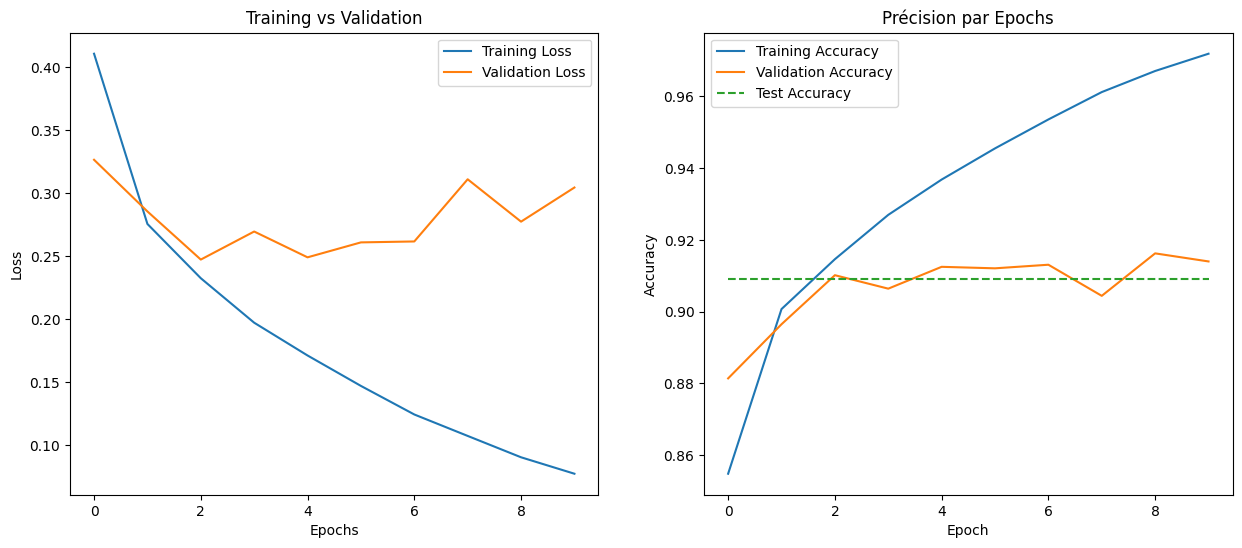

In [73]:
# Évaluer le modèle
test_loss, test_acc = CNN1.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

plt.figure(figsize=(15, 6))
# Tracer les courbes de loss
plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, position 1
plt.plot(history_CNN1.history['loss'], label='Training Loss')
plt.plot(history_CNN1.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Courbes de précision
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, position 2
plt.plot(history_CNN1.history['accuracy'], label='Training Accuracy')
plt.plot(history_CNN1.history['val_accuracy'], label='Validation Accuracy')
plt.plot(np.arange(len(history_CNN1.history['accuracy'])), [test_acc]*len(history_CNN1.history['accuracy']), label='Test Accuracy', linestyle='--')
plt.title('Précision par Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Second modèle CNN

On ajoute du <i>dropout</i> pour réduire le léger sur-apprentisage vu sur le modèle précédent.

In [64]:
CNN2 = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name='Conv2D_input'),
    Dropout(0.25),
    MaxPooling2D(pool_size=(2, 2), name='MaxPooling2D'),
    Dropout(0.5),
    Flatten(name='Flatten'),
    Dense(128, activation='relu', name='hidden_layer_fully_connected'),
    Dense(10, activation='softmax', name='Output')
],name='CNN_2')

CNN2.summary()
CNN2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#model.fit(X_train, Y_train,batch_size=batch_size, nb_epoch=nb_epoch,verbose=1, validation_data=(X_test, Y_test))
history_CNN2 = CNN2.fit(X_train, y_train,batch_size=32, epochs=10,verbose=1,validation_split=0.2)

Model: "CNN_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_input (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 dropout_4 (Dropout)         (None, 26, 26, 32)        0         
                                                                 
 MaxPooling2D (MaxPooling2D  (None, 13, 13, 32)        0         
 )                                                               
                                                                 
 dropout_5 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 Flatten (Flatten)           (None, 5408)              0         
                                                                 
 hidden_layer_fully_connect  (None, 128)               692352    
 ed (Dense)                                                  

# Evaluation 
Nous avons réussi à réduire le léger sur-apprentissage sans dégrader les performances du modèle en test à l'aide du dropout.
On observe ici une précision de 93% en apprentissage et 91% en test. Le modèle est même légèrement meilleur que le précédent.

313/313 [==============================] - 1s 2ms/step - loss: 0.2450 - accuracy: 0.9119
Test accuracy: 91.19%


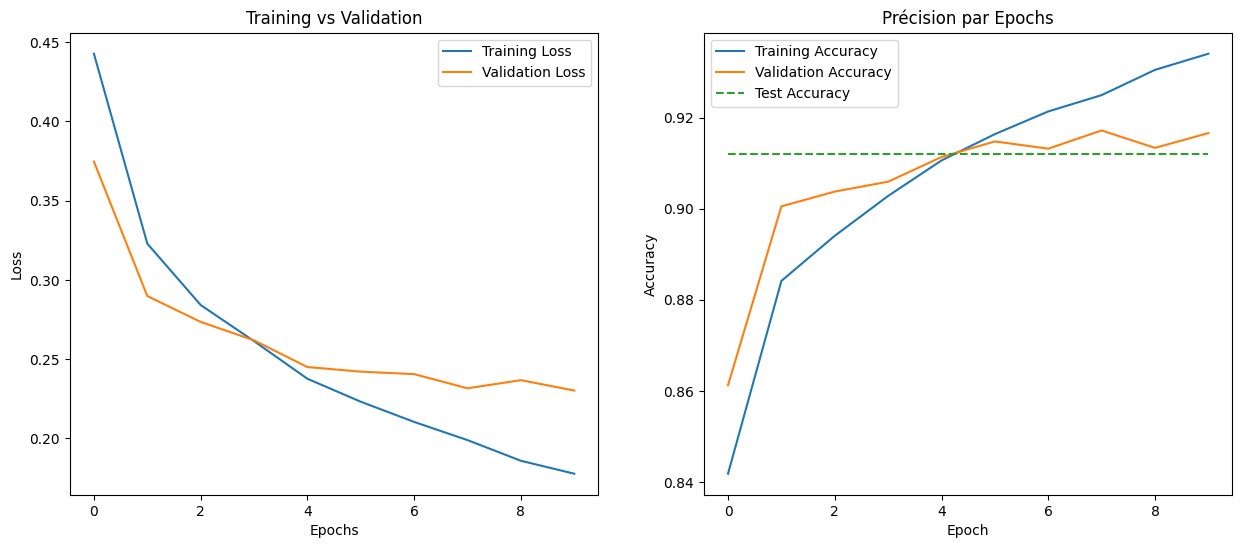

In [69]:
# Évaluer le modèle
test_loss, test_acc = CNN2.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

plt.figure(figsize=(15, 6))
# Tracer les courbes de loss
plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, position 1
plt.plot(history_CNN2.history['loss'], label='Training Loss')
plt.plot(history_CNN2.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Courbes de précision
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, position 2
plt.plot(history_CNN2.history['accuracy'], label='Training Accuracy')
plt.plot(history_CNN2.history['val_accuracy'], label='Validation Accuracy')
plt.plot(np.arange(len(history_CNN2.history['accuracy'])), [test_acc]*len(history_CNN2.history['accuracy']), label='Test Accuracy', linestyle='--')
plt.title('Précision par Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Troisième modèle CNN
Pour ce troisième modèle, nous allons utiliser 5 couches de convolutions. 
<br>Nous allons également introduire un nouveau paramètre pour ces couches en utilisant <b>"padding = same"</b>
<br>Ce paramètre permet de <b>conserver les dimensions</b> de l'image dans la carte des caractéristiques. En effet, dans les modèles précédent, le padding par défaut valait <i>"valid"</i>, ce paramètre réduisait de 2x2 la carte par rapport à l'image (la carte avait donc une dimension 26x26 dès la première couche)

In [108]:
CNN3 = Sequential([
    Conv2D(32, (3, 3), padding='valid', activation='relu', input_shape=input_shape),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
], name='CNN_3')

CNN3.summary()
CNN3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history_CNN3 = CNN3.fit(X_train, y_train,batch_size=32, epochs=10,verbose=1,validation_split=0.2)


Model: "CNN_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_57 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 12, 12, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 12, 12, 32)        0         
                                                                 
 conv2d_58 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_59 (Conv2D)          (None, 10, 10, 64)        36928     
                                                             

1500/1500 [==============================] - 45s 29ms/step - loss: 0.6236 - accuracy: 0.7721 - val_loss: 0.3727 - val_accuracy: 0.8564
Epoch 2/10
1500/1500 [==============================] - 43s 29ms/step - loss: 0.3900 - accuracy: 0.8595 - val_loss: 0.3010 - val_accuracy: 0.8906
Epoch 3/10
1500/1500 [==============================] - 42s 28ms/step - loss: 0.3262 - accuracy: 0.8831 - val_loss: 0.2771 - val_accuracy: 0.9012
Epoch 4/10
1500/1500 [==============================] - 42s 28ms/step - loss: 0.2944 - accuracy: 0.8943 - val_loss: 0.2527 - val_accuracy: 0.9075
Epoch 5/10
1500/1500 [==============================] - 42s 28ms/step - loss: 0.2716 - accuracy: 0.9030 - val_loss: 0.2503 - val_accuracy: 0.9088
Epoch 6/10
1500/1500 [==============================] - 43s 28ms/step - loss: 0.2521 - accuracy: 0.9096 - val_loss: 0.2451 - val_accuracy: 0.9095
Epoch 7/10
1500/1500 [==============================] - 43s 29ms/step - loss: 0.2416 - accuracy: 0.9121 - val_loss: 0.2332 - val_accura

# Evaluation
Bien que le nombre de couches et de filtres soit supérieur, le modèle n'est pas meilleur que le précédent. (91.19% vs 91.21% de précision)

313/313 [==============================] - 3s 9ms/step - loss: 0.2440 - accuracy: 0.9121
Test accuracy: 91.21%


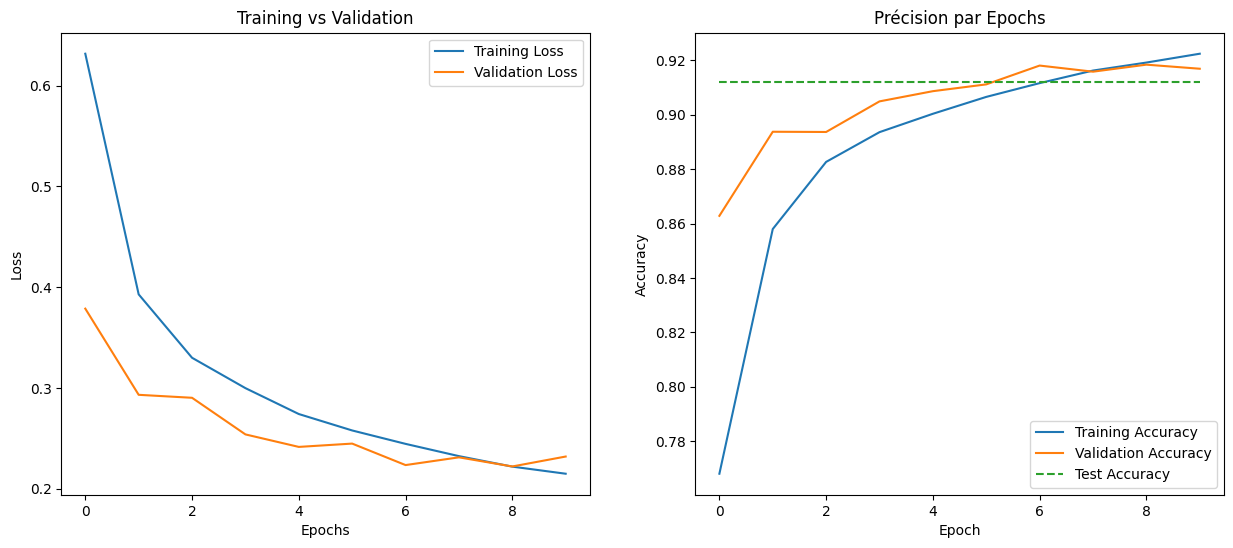

In [89]:
# Évaluer le modèle
test_loss, test_acc = CNN3.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

plt.figure(figsize=(15, 6))
# Tracer les courbes de loss
plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, position 1
plt.plot(history_CNN3.history['loss'], label='Training Loss')
plt.plot(history_CNN3.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Courbes de précision
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, position 2
plt.plot(history_CNN3.history['accuracy'], label='Training Accuracy')
plt.plot(history_CNN3.history['val_accuracy'], label='Validation Accuracy')
plt.plot(np.arange(len(history_CNN3.history['accuracy'])), [test_acc]*len(history_CNN3.history['accuracy']), label='Test Accuracy', linestyle='--')
plt.title('Précision par Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Quatrième modèle CNN

Nous pouvons présumer qu'il y avait peut-être "trop" de couches et que le modèle n'arriait pas à capter des informations lui permettant de s'améliorer. 
Nous allons essayer de le réduire un peu. 

In [91]:
CNN4 = Sequential([
    Conv2D(32, (3, 3), padding='valid', activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=2),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Flatten(),
    
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')    
],name='CNN_4')

CNN4.summary()
CNN4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_CNN4 = CNN4.fit(X_train, y_train,batch_size=32, epochs=10,verbose=1,validation_split=0.2)


Model: "CNN_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 6, 6, 64)          0         
                                                                 
 conv2d_39 (Conv2D)          (None, 6, 6, 128)         73856 

# Evaluation 
Le modèle est légèrement meilleur que le précédent (92.08% vs 91.21%). C'est notre meilleur modèle jusqu'ici.

313/313 [==============================] - 2s 5ms/step - loss: 0.2271 - accuracy: 0.9208
Test accuracy: 92.08%


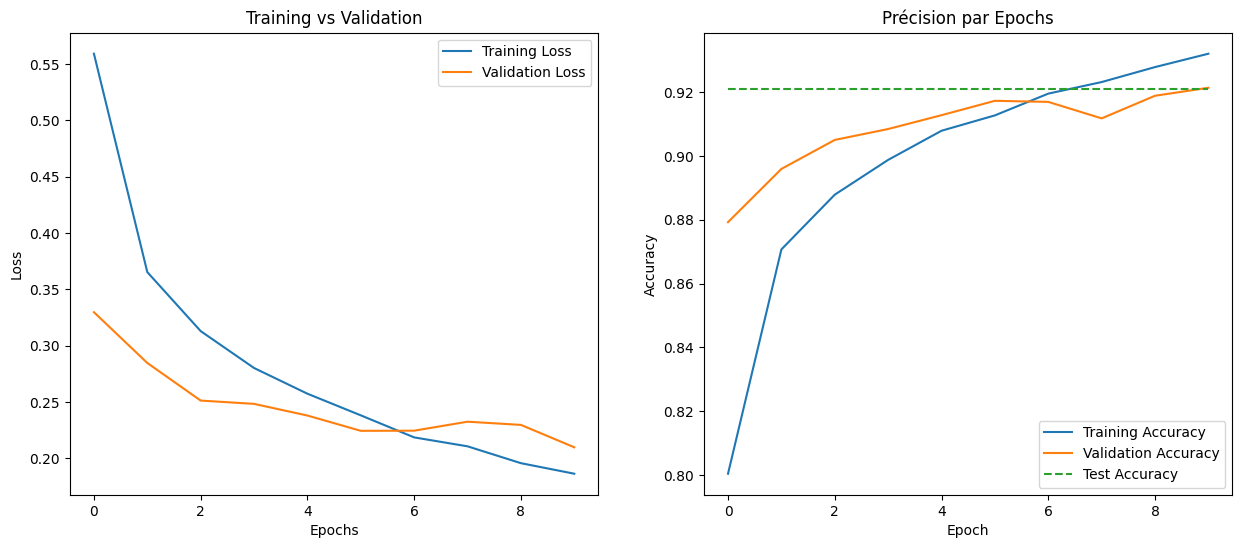

In [92]:
# Évaluer le modèle
test_loss, test_acc = CNN4.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

plt.figure(figsize=(15, 6))
# Tracer les courbes de loss
plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, position 1
plt.plot(history_CNN4.history['loss'], label='Training Loss')
plt.plot(history_CNN4.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Courbes de précision
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, position 2
plt.plot(history_CNN4.history['accuracy'], label='Training Accuracy')
plt.plot(history_CNN4.history['val_accuracy'], label='Validation Accuracy')
plt.plot(np.arange(len(history_CNN4.history['accuracy'])), [test_acc]*len(history_CNN4.history['accuracy']), label='Test Accuracy', linestyle='--')
plt.title('Précision par Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [98]:
CNN5 = Sequential([
    Conv2D(32, (3, 3), padding='valid', activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Flatten(),
    

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')    
],name='CNN_5')

CNN5.summary()
CNN5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_CNN5 = CNN5.fit(X_train, y_train,batch_size=32, epochs=20,verbose=1,validation_split=0.2)

Model: "CNN_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 6, 6, 64)          0         


 ng2D)                                                           
                                                                 
 dropout_26 (Dropout)        (None, 6, 6, 64)          0         
                                                                 
 conv2d_51 (Conv2D)          (None, 6, 6, 128)         73856     
                                                                 
 flatten_14 (Flatten)        (None, 4608)              0         
                                                                 
 dense_27 (Dense)            (None, 128)               589952    
                                                                 
 dropout_27 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 10)                1290      
                                                                 
Total params: 683914 (2.61 MB)
Trainable params: 683914 (2.61 MB)
Non-traina

# Evaluation 
En ayant augmenté le nombre d'epochs de 10 à 20, le modèle ne donne pas de meilleurs résultats (91% vs 92%).
En conclusion, il faut s'y prendre autrement.

313/313 [==============================] - 2s 5ms/step - loss: 0.2601 - accuracy: 0.9129
Test accuracy: 91.29%


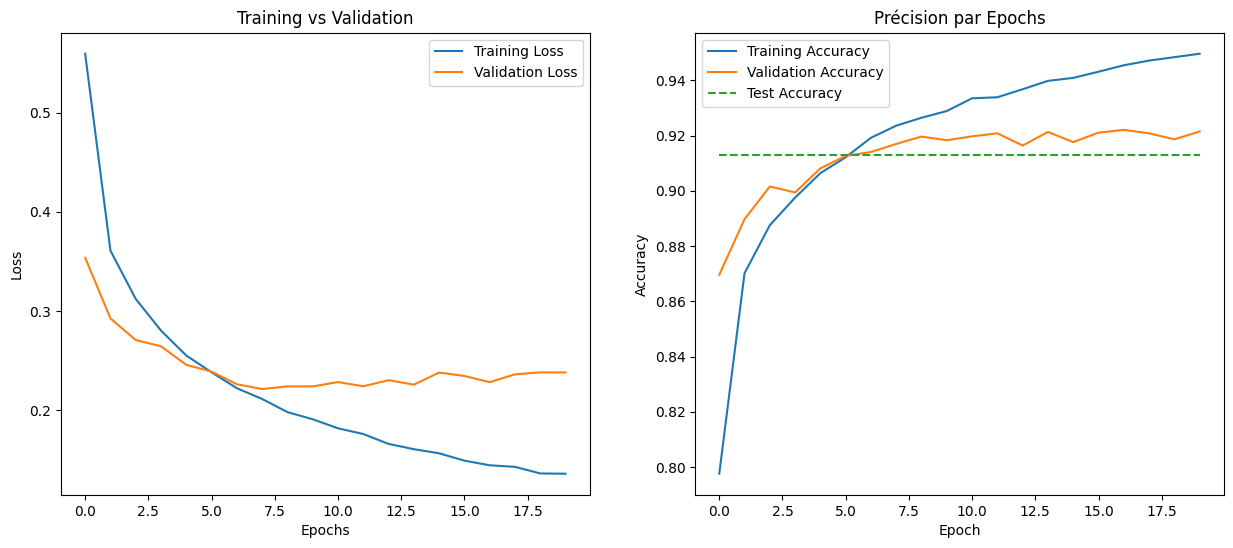

In [102]:
# Évaluer le modèle
test_loss, test_acc = CNN5.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

plt.figure(figsize=(15, 6))
# Tracer les courbes de loss
plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, position 1
plt.plot(history_CNN5.history['loss'], label='Training Loss')
plt.plot(history_CNN5.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Courbes de précision
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, position 2
plt.plot(history_CNN5.history['accuracy'], label='Training Accuracy')
plt.plot(history_CNN5.history['val_accuracy'], label='Validation Accuracy')
plt.plot(np.arange(len(history_CNN5.history['accuracy'])), [test_acc]*len(history_CNN5.history['accuracy']), label='Test Accuracy', linestyle='--')
plt.title('Précision par Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualisations supplémentaires de résultats du meilleur modèle (CNN4)
Nous pouvons visualiser la matrice de confusion de notre meilleur modèle, nous pouvons ainsi visualiser les potentielles confusions commisent par le modèle. 

 12/313 [>.............................] - ETA: 1s

c:\Users\hosfa\Documents\DeeplearningMEDAS\env_name\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 45/313 [===>..........................] - ETA: 1s

313/313 [==============================] - 2s 5ms/step
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


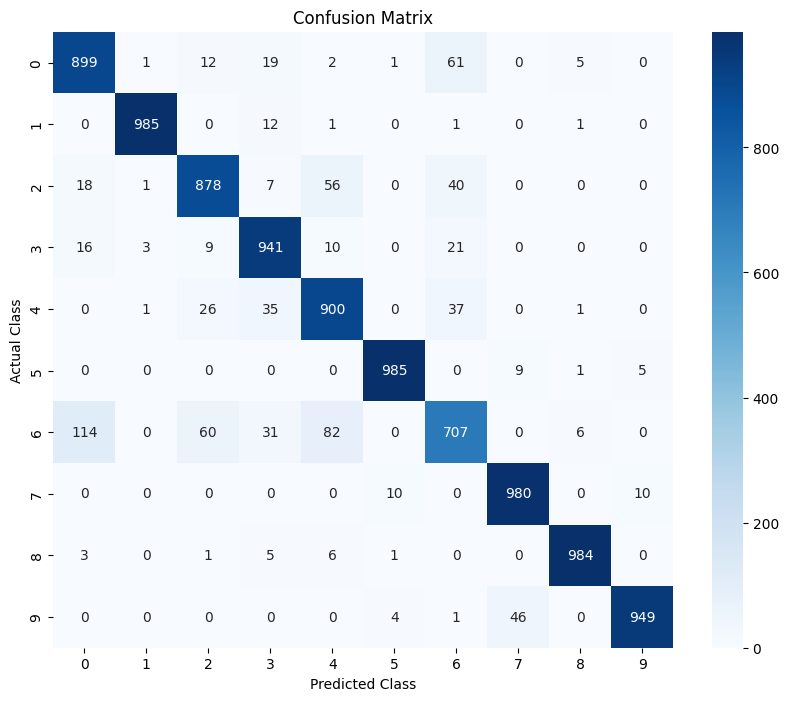

In [109]:
CNN4.save('CNN4.h5')
y_sigmoid = CNN4.predict(X_test)
y_pred = np.argmax(y_sigmoid, axis=-1)
y_test_class = np.argmax(y_test, axis=-1)

print(class_names)

cm = confusion_matrix(y_test_class, y_pred)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


<p>Nous pouvons faire quelques commentaires sur la matrice, nous voyons notamment que le modèle se trompe souvent entre les <b>T-shirt(0)</b> et les <b>chemises(6)</b>. Les <b>robes</b> sont elles aussi confondues avec les <b>chemises</b>.</p>
<p>La classe la moins bien prédite est de ce fait la classe 6 avec <b>seulement 707 observations</b> bien classés alors que les autres dépassent souvent le seuil des 900 observations bien classées. 
A titre personnel, je suis étonné de voir que le modèle a du mal à différencier une chemise d'un t-shirt, mais qu'il arrive sans problème à différencier une sneaker, d'une sandale et d'une bottine. 

### Voir les bonnes prédictions

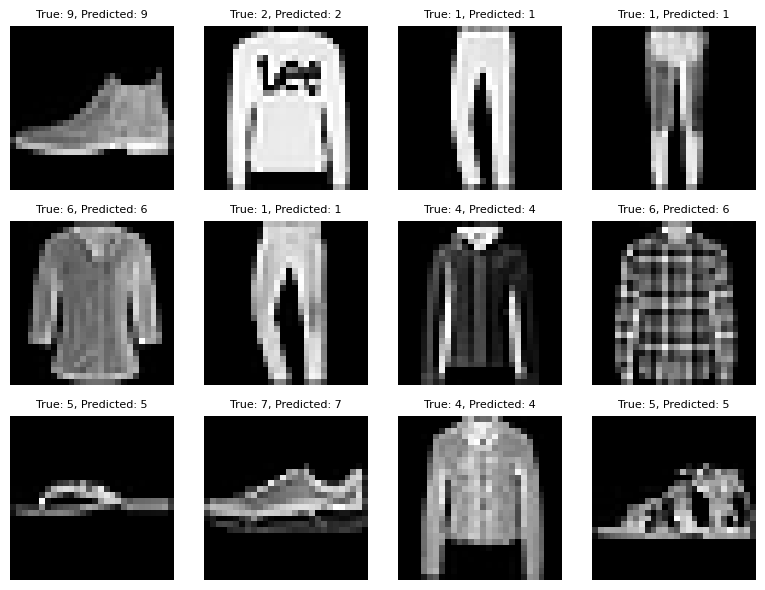

In [106]:
num_images = 12
num_cols = 4
num_rows = num_images // num_cols

plt.figure(figsize=(2 * num_cols, 2 * num_rows))

for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_test[i], cmap='gray')  
    
    plt.title(f"True: {y_test_class[i]}, Predicted: {y_pred[i]}", fontsize=8)
    plt.axis('off')

plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.tight_layout()
plt.show()

### Voir les images où le modèle se trompe

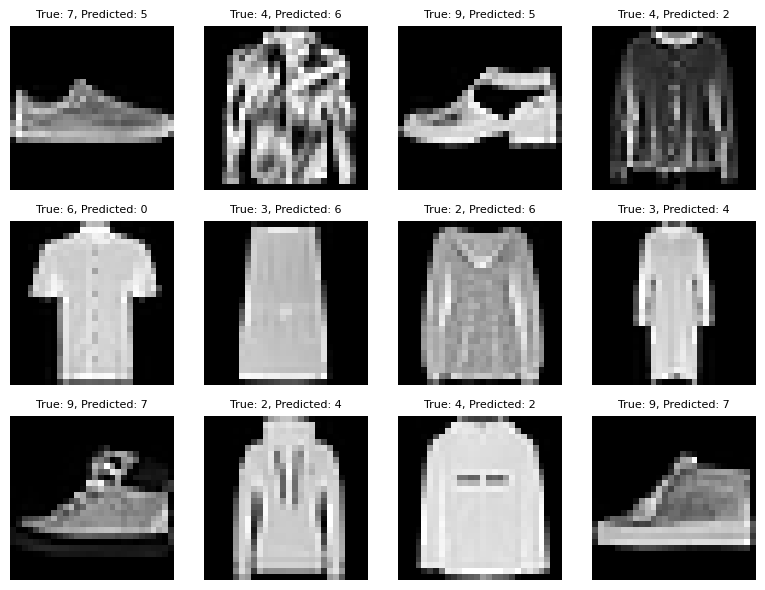

In [107]:
incorrect_indices = np.where(y_pred != y_test_class)[0]
num_images = 12 
if len(incorrect_indices) < num_images:
    num_images = len(incorrect_indices)

num_cols = 4
num_rows = num_images // num_cols + (num_images % num_cols > 0)


plt.figure(figsize=(2 * num_cols, 2 * num_rows))

for i in range(num_images):
    idx = incorrect_indices[i] 
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_test[idx], cmap='gray') 
    plt.title(f"True: {y_test_class[idx]}, Predicted: {y_pred[idx]}", fontsize=8)
    plt.axis('off')

plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.tight_layout()
plt.show()

# Mot de la fin / Pour aller plus loin

<p>Pour aller plus loin, nous pourrions utiliser la fonctionnalité <b>Hyperband</b> fournis par Keras. 
Cette fonction permet de faire une <b>recherche optimale des paramètres</b> en fonction d'un <b>critère</b>, par exemple, la précision. 
Ce processus itératif va tester une combinaison de paramètres en réalisant plusieurs modèles en parralèle et abandonnera ceux qui ne semblent pas pertinent pour maximiser le critère choisi. </p>
<p>De plus, il faudrait également tester les <b>différentes fonctions de pertes et d'activation disponibles</b> mais aussi utiliser une validation croisée. En effet, les résultats obtenus dans ce TP viennent d'un seul modèle, cependant <b>le processus stochastique</b> de la descente de gradient implique que mes résultats sont les miens à <b>l'instant T</b>. Une meilleure métrique serait <b>la moyenne de la précision</b> sur un ensemble de modèle. </p>

<p>Je ne le lancerai pas dans ce projet par manque de ressources, c'est un processus très long. </p>
<p>Par ailleurs, les résultats obtenus ne seraient peut-être pas forcément bien meilleur, il sûrement nécessaire de changer de type de réseaux pour obtenir de meilleures performances sur le jeu de données Fashion-MNIST.</p>

In [ ]:
def build_model(hp):
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)),
        
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)),
        
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        Flatten(),
        
        Dense(128, activation='relu'),
        Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)),
        Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Hyperband
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    executions_per_trial=2,
    directory='models',
    project_name='Fashion_MNIST_hyperband'
)

# Recherche des meilleurs hyperparamètres
tuner.search(X_train, y_train, validation_split=0.2, batch_size=32)

# Affichage des meilleurs hyperparamètres
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_epoch = tuner.get_best_models(num_models=1)[0].history.epoch[-1] + 1
print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best dropout 1 rate: {best_hps.get('dropout_1')}")
print(f"Best dropout 2 rate: {best_hps.get('dropout_2')}")
print(f"Best dropout 3 rate: {best_hps.get('dropout_3')}")
print(f"Best number of epochs: {best_epoch}")
